In [1]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard
import time

In [4]:
model_name = "raw"
CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/original/train"
NAME = "Covid-"+model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

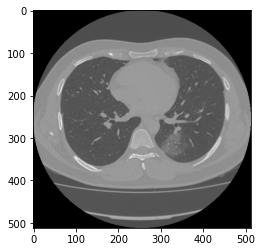

In [5]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [11]:
# Data Augmentation

IMAGE_SIZE    = (244, 244)

BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 200
LEARNING_RATE =0.0005 

train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip= True ,
    validation_split = 0.2)

In [7]:
print("Training samples:")
train_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="binary")

print("\n Validation samples: ")
                                                  

valid_batches = train_datagen.flow_from_directory(DATADIR,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="binary" )





Training samples:
Found 8988 images belonging to 2 classes.

 Validation samples: 
Found 2245 images belonging to 2 classes.


In [8]:
# Output classes
train_batches.class_indices

{'covid': 0, 'normal': 1}

In [71]:

df = pd.DataFrame()
df["labels"] = list(train_batches.classes)

In [44]:
df["labels"].value_counts()

0    4576
1    4412
Name: labels, dtype: int64

In [9]:
len(train_batches.classes)

8988

##  Distribution of classes

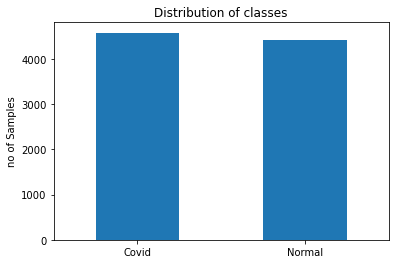

In [46]:
df["labels"].value_counts().plot(kind='bar')
plt.xticks([0,1], ["Covid", "Normal"], rotation='horizontal')
plt.ylabel('no of Samples')
plt.title('Distribution of classes')
plt.show()

In [10]:
# Model Structure
model = Sequential()

model.add(Conv2D( 32, kernel_size=(3,3),activation='relu',input_shape=(244, 244,3)))

model.add(Conv2D( 128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D( 64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(64, activation='relu'))
#remove dropout - 0.2
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss = keras.losses.binary_crossentropy, optimizer = 'adam', metrics = ['accuracy'])

In [12]:
result = model.fit_generator(train_batches,
                        steps_per_epoch = len(train_batches),
                        validation_data = valid_batches,
                        validation_steps = len(valid_batches),
                        epochs= NUM_EPOCHS,
                        callbacks=[tensorboard])


c:\Users\ranji\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
281/281 [==============================] - ETA: 0s - loss: 0.5485 - accuracy: 0.7493WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000184AEDCCEE8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

In [13]:
model.save("D:/Project2022/models/image/"+model_name+".h5")

## Evaluating the model on Test dataset

In [14]:
test_dir = "D:/Project2022/res/split_dataset/original/test"

test_datagen = image.ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=False,
        seed=42,      
        class_mode="binary")

Found 2809 images belonging to 2 classes.


In [15]:
x = model.evaluate(eval_generator,
                       steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                       use_multiprocessing = False,
                       verbose = 1,
                       workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

88/88 [==============================] - 2s 12ms/step - loss: 0.0627 - accuracy: 0.9659
Test loss: 0.06274330615997314
Test accuracy: 0.9659090638160706


In [16]:
pred = model.predict(eval_generator,len(eval_generator.classes),verbose=1)
print("Predictions finished")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2809/2809 [==============================] - 31s 11ms/step
Predictions finished


In [17]:
y_test = eval_generator.classes
y_pred = (pred > 0.5).astype("int32")

In [18]:
from sklearn.metrics import classification_report 
print(classification_report(eval_generator.classes, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.98      0.95      0.97      1430
      Normal       0.95      0.98      0.97      1379

    accuracy                           0.97      2809
   macro avg       0.97      0.97      0.97      2809
weighted avg       0.97      0.97      0.97      2809



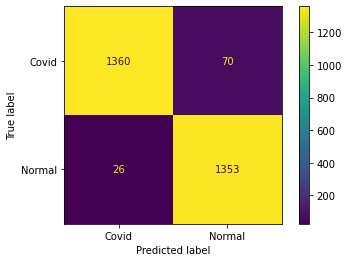

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(eval_generator.classes, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
